In [238]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [239]:
file_path = 'Project/measures_v2.csv'

df = pd.read_csv(file_path)

df.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,0.187101,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,0.245417,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,0.176615,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,0.238303,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,0.208197,17


In [240]:
# This function applies z-score normalization to all the features in the dataset except from the profile id
def apply_z_score_normalization_except_profile_id(df):

    profile_id = df['profile_id']
    df_to_scale = df.drop('profile_id', axis=1)

    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_to_scale)

    df_scaled = pd.DataFrame(df_scaled, columns=df_to_scale.columns)

    df_scaled['profile_id'] = profile_id

    return df_scaled

In [241]:
df_norm = apply_z_score_normalization_except_profile_id(df)

In [242]:
# Desired average segment length
average_segment_length = 2  # Example value

# Initialize a DataFrame to store the PAA-transformed data
paa_transformed_data = pd.DataFrame()

# Iterate over each unique profile_id
for profile_id in df_norm['profile_id'].unique():
    profile_data = df_norm[df_norm['profile_id'] == profile_id]

    # Select multiple columns correctly using a list
    columns_to_transform = ['u_q', 'coolant', 'stator_winding',	'u_d',	'stator_tooth',	'motor_speed',	'i_d',	'i_q',	'pm',	'stator_yoke',	'ambient', 'torque']
    time_series_data = profile_data[columns_to_transform]

    # Calculate the number of segments
    series_length = len(time_series_data)
    num_segments = max(1, series_length // average_segment_length)  # Ensure at least one segment

    # Initialize a DataFrame to hold the PAA-transformed series for this profile_id
    paa_transformed = pd.DataFrame(index=range(num_segments), columns=columns_to_transform)

    # Calculate the length of each segment
    segment_length = series_length // num_segments

    # Loop over the segments and compute the mean for each column
    for i in range(num_segments):
        start_idx = i * segment_length
        end_idx = min(start_idx + segment_length, series_length)  # Ensure not to exceed series length
        segment_means = profile_data[start_idx:end_idx][columns_to_transform].mean()
        paa_transformed.iloc[i] = segment_means

    # Add profile_id to the transformed DataFrame
    paa_transformed['profile_id'] = profile_id

    # Add the PAA-transformed data for this profile_id to the main DataFrame
    paa_transformed_data = pd.concat([paa_transformed_data, paa_transformed], ignore_index=True)

# paa_transformed_data contains the reduced representation of your time-series for each profile_id


In [243]:
def add_ewa_features_by_profile_id(df, spans, exclude_columns):
    
    exclude_columns = set(exclude_columns) | {'profile_id'}
    original_columns = [col for col in df.columns if col not in exclude_columns]

    # Iterate over each original column
    for col in original_columns:
        # Apply EWA for each span value
        for span in spans:
            ewa_col_name = f'{col}_ewa_{span}'

            # Group by 'profile_id' and apply EWA using transform
            ewa_col = df.groupby('profile_id')[col].transform(lambda x: x.ewm(span=span, adjust=False).mean())

            # Add the new EWA column to the DataFrame
            df[ewa_col_name] = ewa_col

    return df

In [244]:
exclude_columns = ['stator_winding']

spans = [600]

data_df = add_ewa_features_by_profile_id(paa_transformed_data, spans, exclude_columns)

data_df.head()

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 665394 entries, 0 to 665393
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   u_q                   665394 non-null  object 
 1   coolant               665394 non-null  object 
 2   stator_winding        665394 non-null  object 
 3   u_d                   665394 non-null  object 
 4   stator_tooth          665394 non-null  object 
 5   motor_speed           665394 non-null  object 
 6   i_d                   665394 non-null  object 
 7   i_q                   665394 non-null  object 
 8   pm                    665394 non-null  object 
 9   stator_yoke           665394 non-null  object 
 10  ambient               665394 non-null  object 
 11  torque                665394 non-null  object 
 12  profile_id            665394 non-null  int64  
 13  u_q_ewa_600           665394 non-null  float64
 14  coolant_ewa_600       665394 non-null  float64
 15  

In [245]:
# Hyperparameters (downsampling, train/dev/test-split, feature selection, ...)
downsample_rate = 2
n_dev = 2 
n_test = 1
features = ['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q', 'u_s', 'i_s', 's_el']
feature_len = len(features)
target = ['stator_winding']

In [246]:
IDs = np.array(data_df['profile_id'].unique())

In [247]:
# Creates single sample array of shape (1, T, n)
def get_single_sample(df, n_feat, sample_len, downsample_rate=1):
    
    # Get new length for downsampling
    new_len = int(np.floor((max_len + downsample_rate - 1) / downsample_rate) * downsample_rate)
    
    # Convert df to numpy array of shape (1, T, n)
    arr = df.to_numpy()
    arr = np.expand_dims(arr, axis=0)
    
    # Zero-pad to sample_len at the end of the array
    _arr = np.zeros((1, new_len - np.size(arr, 1), n_feat))
    sample = np.concatenate((arr, _arr), axis=1)
    
    # Get sample_weights (zero-padded elements should have zero weight)
    weights = np.concatenate((np.ones(arr.shape), np.zeros(_arr.shape)), axis=1)
    weights = weights[:,:,0]
    
    # Perform Downsampling
    dwn_sample = []
    dwn_weights = []
    for d in np.arange(1,downsample_rate+1):
        dwn_sample.append(sample[:,(-1+d)::downsample_rate,:])
        dwn_weights.append(weights[:,(-1+d)::downsample_rate])
    
    sample = np.concatenate(dwn_sample, axis=0)
    weights = np.concatenate(dwn_weights, axis=0)
        
    return sample, weights

In [248]:
features = data_df.columns

features = [elem for elem in features if elem != 'stator_winding']
features = [elem for elem in features if elem != 'profile_id']
feature_len = len(features)

print(features)

print(len(features))

['u_q', 'coolant', 'u_d', 'stator_tooth', 'motor_speed', 'i_d', 'i_q', 'pm', 'stator_yoke', 'ambient', 'torque', 'u_q_ewa_600', 'coolant_ewa_600', 'u_d_ewa_600', 'stator_tooth_ewa_600', 'motor_speed_ewa_600', 'i_d_ewa_600', 'i_q_ewa_600', 'pm_ewa_600', 'stator_yoke_ewa_600', 'ambient_ewa_600', 'torque_ewa_600']
22


In [249]:
# Prepare Data for use with LSTMs: Data needs to be in shape (m, T, n)

# get maximum length, select features and target
max_len = data_df.groupby(['profile_id']).size().max()
print(max_len)

# Prepare index for faster iteration
iter_df = data_df.copy() # copy increases memory use, but avoids errors when executed twice. Better solution?
iter_df['idx'] = data_df.index
iter_df.set_index(['profile_id', 'idx'], inplace = True)

# create (m, T, n) array for X_values, sample_weights and Y_values
batch_samples_X = []
batch_weights_X = []
batch_samples_Y = []

for pid in IDs:
    # select profile
    df = iter_df.loc[pid]
    # get X samples and weights
    sample, weights = get_single_sample(df[features], 22, max_len, downsample_rate)
    batch_samples_X.append(sample)
    batch_weights_X.append(weights)    
    # get Y samples
    sample, _ = get_single_sample(df[target], 1, max_len, downsample_rate)
    batch_samples_Y.append(sample)
    
X_vals = np.concatenate(batch_samples_X, axis=0)
X_weights = np.concatenate(batch_weights_X, axis=0)
Y_vals = np.concatenate(batch_samples_Y, axis=0)

print('Shape of batches')
print('X_vals:    ', X_vals.shape)
print('X_weights: ', X_weights.shape)
print('Y_vals:    ', Y_vals.shape)

21985
Shape of batches
X_vals:     (138, 10993, 22)
X_weights:  (138, 10993)
Y_vals:     (138, 10993, 1)


In [250]:
# Create train-dev-test-split for LSTMs
# (when cycles are downsampled, all downsampled parts should belong to the same set)
X_train = X_vals[:-(n_dev+n_test)*downsample_rate,:,:]
X_train_weights = X_weights[:-(n_dev+n_test)*downsample_rate,:]
Y_train = Y_vals[:-(n_dev+n_test)*downsample_rate,:,:]

X_dev = X_vals[-((n_dev+n_test)*downsample_rate):-(n_test)*downsample_rate,:,:]
X_dev_weights = X_weights[-((n_dev+n_test)*downsample_rate):-(n_test)*downsample_rate,:]
Y_dev = Y_vals[-((n_dev+n_test)*downsample_rate):-(n_test)*downsample_rate,:,:]

X_test = X_vals[-((n_test)*downsample_rate):,:,:]
X_test_weights = X_weights[-((n_test)*downsample_rate):,:]
Y_test = Y_vals[-((n_test)*downsample_rate):,:,:]

print('Shape of train-test-split')
print('train (X, weights, Y): ', X_train.shape, X_train_weights.shape, Y_train.shape)
print('dev (X, weights, Y):   ', X_dev.shape, X_dev_weights.shape, Y_dev.shape)
print('test (X, weights, Y):  ', X_test.shape, X_test_weights.shape, Y_test.shape)

Shape of train-test-split
train (X, weights, Y):  (132, 10993, 22) (132, 10993) (132, 10993, 1)
dev (X, weights, Y):    (4, 10993, 22) (4, 10993) (4, 10993, 1)
test (X, weights, Y):   (2, 10993, 22) (2, 10993) (2, 10993, 1)


In [251]:
X_train = X_train.astype('float32')
Y_train = Y_train.astype('float32')
X_dev = X_dev.astype('float32')
Y_dev = Y_dev.astype('float32')
X_train_weights = X_train_weights.astype('float32')
X_dev_weights = X_dev_weights.astype('float32')

In [252]:
n_epochs = 25
lr = 0.01
lr_decay = 1e-2
dropout_rate = 0.1
n_units = 32
n_dense_in = 16
n_dense_mid = 8
n_dense_out = 1

In [253]:
# Plots the loss over all epochs and a zoom on the last 20 epochs.
def plot_learning_curves(history, descr=' '):

    # get results
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss)) 
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # loss
    axes[0].plot(epochs, loss, 'r')
    axes[0].plot(epochs, val_loss, 'b')
    axes[0].set_title('Loss - Train vs. Validation')
    axes[0].legend(['Train', 'Validation'])
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('loss')
    
    
    fig.suptitle(descr, fontsize="x-large", fontweight='bold')
    
    return

In [254]:
simple_lstm = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(n_units, return_sequences=True, input_shape=[None, feature_len]),
  tf.keras.layers.Dense(n_dense_mid, activation="relu"),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(n_dense_out),
])

simple_lstm.summary()

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr, 
                                     decay=lr_decay,
                                     beta_1=0.9, beta_2=0.999, amsgrad=False)

simple_lstm.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mse'],
              sample_weight_mode='temporal')

print('Training...')

history = simple_lstm.fit(x=X_train, y=Y_train, 
                          validation_data=(X_dev, Y_dev, X_dev_weights), 
                          sample_weight=X_train_weights, 
                          epochs=n_epochs,
                          verbose=1)

print('Training Completed')

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, None, 32)          7040      
                                                                 
 dense_24 (Dense)            (None, None, 8)           264       
                                                                 
 dropout_12 (Dropout)        (None, None, 8)           0         
                                                                 
 dense_25 (Dense)            (None, None, 1)           9         
                                                                 
Total params: 7,313
Trainable params: 7,313
Non-trainable params: 0
_________________________________________________________________
Training...
Epoch 1/25


2023-12-17 15:02:49.811142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-17 15:02:49.811621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-17 15:02:49.812046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 [==============================] - ETA: 0s - loss: 0.2179 - mse: 0.2193WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


2023-12-17 15:03:00.319068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-17 15:03:00.319890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-17 15:03:00.320331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 [==============================] - 11s 2s/step - loss: 0.2179 - mse: 0.2193 - val_loss: 0.0451 - val_mse: 0.0534
Epoch 2/25
5/5 [==============================] - 10s 2s/step - loss: 0.0695 - mse: 0.0836 - val_loss: 0.0355 - val_mse: 0.0474
Epoch 3/25
5/5 [==============================] - 10s 2s/step - loss: 0.0532 - mse: 0.0664 - val_loss: 0.0291 - val_mse: 0.0425
Epoch 4/25
5/5 [==============================] - 10s 2s/step - loss: 0.0479 - mse: 0.0623 - val_loss: 0.0291 - val_mse: 0.0410
Epoch 5/25
5/5 [==============================] - 10s 2s/step - loss: 0.0392 - mse: 0.0515 - val_loss: 0.0177 - val_mse: 0.0288
Epoch 6/25
5/5 [==============================] - 10s 2s/step - loss: 0.0337 - mse: 0.0469 - val_loss: 0.0177 - val_mse: 0.0316
Epoch 7/25
5/5 [==============================] - 10s 2s/step - loss: 0.0303 - mse: 0.0453 - val_loss: 0.0137 - val_mse: 0.0270
Epoch 8/25
5/5 [==============================] - 10s 2s/step - loss: 0.0275 - mse: 0.0416 - val_loss: 0.0125 - val

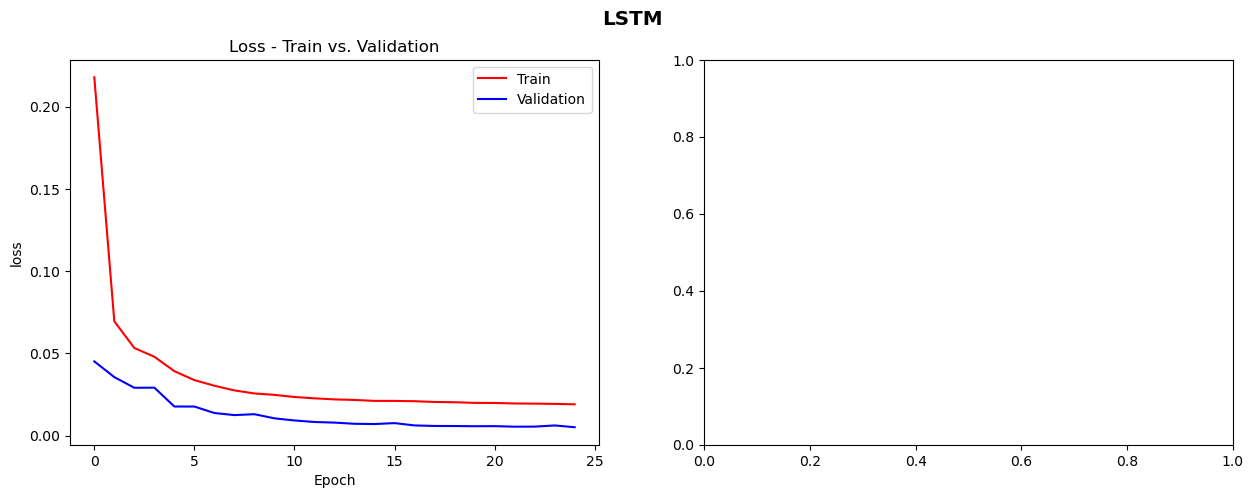

In [255]:
plot_learning_curves(history, descr = 'LSTM')

In [256]:
# This function makes a prediction on a given X of shape (1,Tx,1).
# The first skip_values are truncated, because initial temperature states may have large error.
# Also, only "not-zero-padded" part of the sequence is taken into account (-> sample_weight = 1).
def eval_model(model, X, Y, weights, skip_values=10, scaler=None):
    # prepare data for prediction
    end_sequence = np.where(weights==0)[1][0] # get "real" (= not-zero-padded) end of sequence
    X_pred = X[:,:end_sequence,:]
    Y_truth = Y[0,:end_sequence,0]

    # predict (and rescale if necessary)
    Y_pred = model.predict(X_pred)
    if scaler:
        Y_pred = scaler.inverse_transform(Y_pred)     
    Y_pred = Y_pred[0,:,0]
    
    # skip the first few values (large errors due to initialization phase)
    Y_pred = Y_pred[skip_values:]
    Y_truth = Y_truth[skip_values:]
        
    # calculate errors
    abs_error = np.abs(Y_pred-Y_truth)
    mse_error = np.mean(abs_error**2)    
    
    return Y_pred, Y_truth, abs_error, mse_error

# This function outputs a plot showing the prediction vs. ground truth and the corresponding error.
def plot_prediction(Y_pred, Y_truth, abs_error, mse_error, descr=' '):

    fig, axes = plt.subplots(1, 2, sharex = True, figsize=(15, 5))

    # Temperature values
    axes[0].plot(Y_truth, 'r')
    axes[0].plot(Y_pred, 'b')
    axes[0].set_title('Prediction vs. ground truth')
    axes[0].legend(['Truth', 'Prediction'])
    axes[0].set_xlabel('sample')
    axes[0].set_ylabel('Temperature')
    
    # Error
    axes[1].plot(abs_error, 'r')
    axes[1].set_title('Error (total MSE: {:.5f})'.format(mse_error))
    axes[1].set_xlabel('sample')
    axes[1].set_ylabel('Error')
    
    fig.suptitle(descr, fontsize="x-large", fontweight='bold')

    return

2023-12-17 15:06:57.728246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-17 15:06:57.728878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-17 15:06:57.729628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 330ms/step


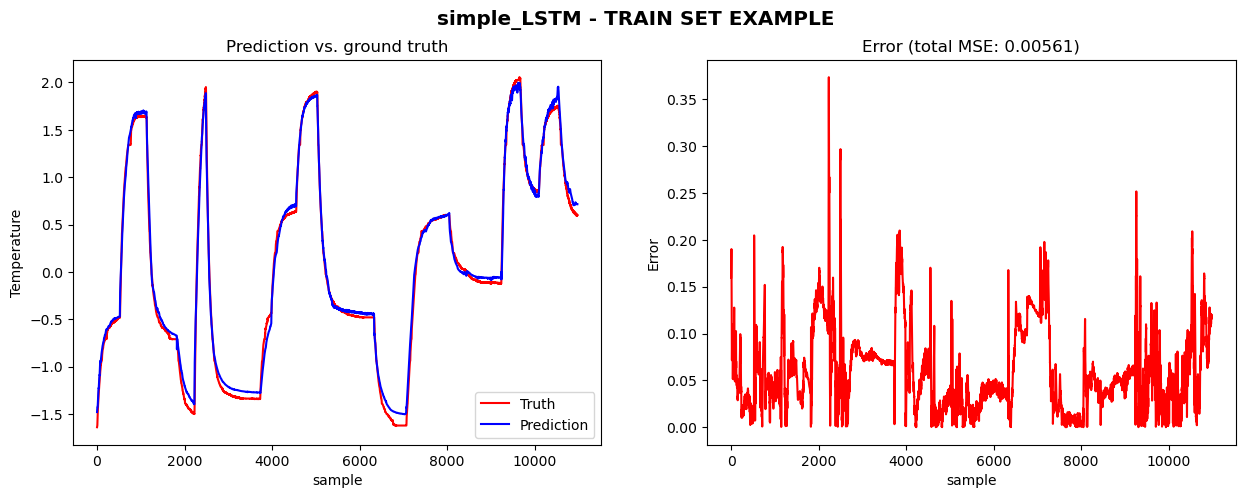

In [257]:
# Plot prediction vs. ground truth for one sample of training set

# training set
pid = 49 # basically a random load cycle
X_pred_train = X_train[pid:pid+1,:,:]
Y_truth_train = Y_train[pid:pid+1,:,:]
weights_train = X_train_weights[pid:pid+1,:]
Y_pred, Y_truth, abs_error, mse_error = eval_model(simple_lstm, X_pred_train, Y_truth_train, weights_train)
plot_prediction(Y_pred, Y_truth, abs_error, mse_error, descr='simple_LSTM - TRAIN SET EXAMPLE')

1/1 [==============================] - 0s 218ms/step


2023-12-17 15:06:58.228557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-17 15:06:58.229080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-17 15:06:58.229766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Test MSE for profile ID 1: 0.01272


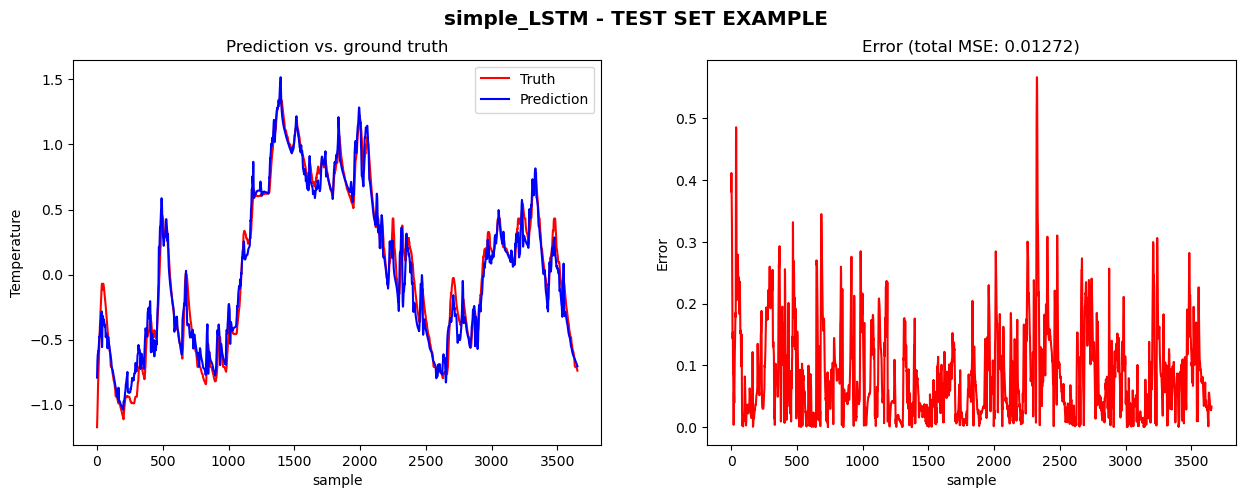

In [258]:
# Pick a random load cycle from the testing set for evaluation
pid_test = np.random.choice(len(X_test))  # Replace with a specific ID if needed
X_pred_test = X_test[pid_test:pid_test+1,:,:]
Y_truth_test = Y_test[pid_test:pid_test+1,:,:]
weights_test = X_test_weights[pid_test:pid_test+1,:]
X_pred_test = X_pred_test.astype('float32')
Y_truth_test = Y_truth_test.astype('float32')
weights_test = weights_test.astype('float32')

# Evaluate the model
Y_pred_test, Y_truth_test_arr, abs_error_test, mse_error_test = eval_model(simple_lstm, X_pred_test, Y_truth_test, weights_test)

# Plot the prediction vs. ground truth for the testing set
plot_prediction(Y_pred_test, Y_truth_test_arr, abs_error_test, mse_error_test, descr='simple_LSTM - TEST SET EXAMPLE')

# Print out the MSE for this particular testing sample
print(f'Test MSE for profile ID {pid_test}: {mse_error_test:.5f}')

In [259]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_test = X_test.astype('float32')
# Predict on the entire testing set
Y_pred_test_all = simple_lstm.predict(X_test)
Y_truth_test_all = Y_test.squeeze()


# Reshape predictions and true values for metric calculations
Y_pred_test_all_flat = Y_pred_test_all.ravel()
Y_truth_test_all_flat = Y_truth_test_all.ravel()

# Calculate MSE
mse_test = mean_squared_error(Y_truth_test_all_flat, Y_pred_test_all_flat)

# Calculate RMSE
rmse_test = np.sqrt(mse_test)

# Calculate MAE
mae_test = mean_absolute_error(Y_truth_test_all_flat, Y_pred_test_all_flat)

# Calculate R-squared
r2_test = r2_score(Y_truth_test_all_flat, Y_pred_test_all_flat)

# Print the metrics
print(f'Test MSE: {mse_test:.5f}')
print(f'Test RMSE: {rmse_test:.5f}')
print(f'Test MAE: {mae_test:.5f}')
print(f'Test R-squared: {r2_test:.5f}')


1/1 [==============================] - 0s 188ms/step
Test MSE: 0.01523
Test RMSE: 0.12340
Test MAE: 0.11367
Test R-squared: 0.87980
